In [1]:
import h5py
import psana
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import  rotate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit,minimize
import multiprocessing
import os
from functools import partial
import time
import sys
import argparse
from datetime import datetime
import tempfile
import XSpect.XSpect_Analysis
import XSpect.XSpect_Controller
import XSpect.XSpect_Visualization

### Running XES Analysis with Droplets

In [2]:
start = time.time()

xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='xcs',experiment_id='xcsl1049023',lcls_run=23)
xes1=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
keys=['epics/ccm_E','tt/ttCorr','epics/lxt_ttc', 'enc/lasDelay' , 'ipm4/sum', 'tt/AMPL'] 
names=['ccm','time_tool_correction','lxt_ttc'  ,'encoder','ipm', 'time_tool_ampl']

#Here we define the epix detector keys separately as they are imported separately to avoid OOM
xes1.key_epix=['epix_2/ROI_0_area']
xes1.friendly_name_epix=['epix']

##
xes1.set_key_aliases(keys,names)
#xes.end_index=5000


xes1.mintime    = -2
xes1.maxtime    = 10
xes1.time_step  = 0.1 # time bin step size in ps
xes1.time_bins  = np.arange(xes1.mintime, xes1.maxtime, xes1.time_step)

xes1.use_droplets = True
xes1.rois         = [ [85, 100], [220, 235] ]
xes1.combine_rois = False
xes1.adu_cutoff   = 3.5
xes1.angle        = .9

# xes.lxt_key=None

xes1.transpose=False
xes1.add_filter('xray','ipm',100.0E3)
xes1.add_filter('simultaneous','ipm',100.0E3)
xes1.add_filter('simultaneous','time_tool_ampl',0.01)

xes1.run_parser(['50-52 68-70 73-74 80 84-86'])

In [3]:
start=time.time()
# analyzed = xes.primary_analysis(xes_experiment,xes.runs[0],verbose=True)
# xes1.primary_analysis_loop(xes_experiment, verbose = True)
xes1.primary_analysis_parallel_range(16,xes_experiment,increment=8000,verbose=False)

end=time.time()
print('Analysis completed: %.02f s' % (end - start))

Processing: 100%|██████████| 60/60 [02:07<00:00,  2.13s/Shot_Batch]

Analysis completed: 134.81 s


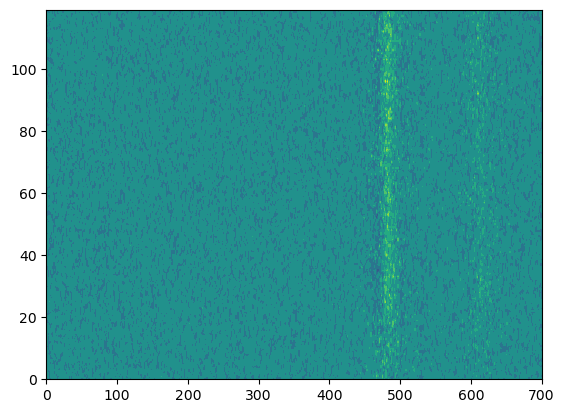

In [6]:
plt.contourf(xes1.epix_ROI_1_summed_normalized_difference)

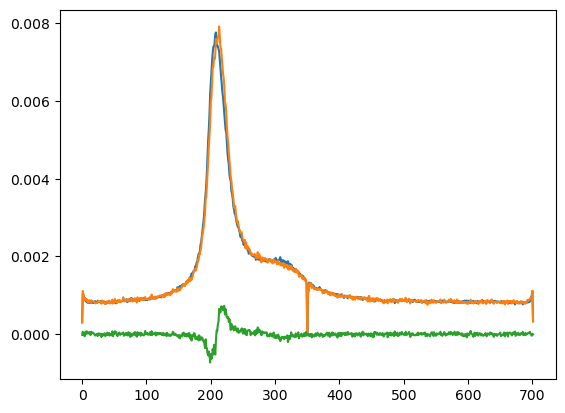

In [5]:
plt.plot(np.nanmean(xes1.epix_ROI_2_summed_laser_off_normalized, axis = 0))
plt.plot(np.nanmean(xes1.epix_ROI_2_summed_laser_on_normalized, axis = 0))
plt.plot(np.nanmean(xes1.epix_ROI_2_summed_normalized_difference, axis = 0))

In [ ]:
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='xcs',experiment_id='xcsl1049023',lcls_run=23)
xes2=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
keys=['epics/ccm_E','tt/ttCorr','epics/lxt_ttc', 'enc/lasDelay' , 'ipm4/sum', 'tt/AMPL'] 
names=['ccm','time_tool_correction','lxt_ttc'  ,'encoder','ipm', 'time_tool_ampl']

#Here we define the epix detector keys separately as they are imported separately to avoid OOM
xes2.key_epix=['epix_2/ROI_0_area']
xes2.friendly_name_epix=['epix']

##
xes2.set_key_aliases(keys,names)
#xes.end_index=5000


xes2.mintime    = -0.5
xes2.maxtime    = 10
xes2.time_step  = 0.1 # time bin step size in ps
xes2.time_bins  = np.arange(xes2.mintime, xes2.maxtime, xes2.time_step)

xes2.use_droplets = False
xes2.rois         = [ [35, 60], [170, 200] ]
xes2.combine_rois = False
xes2.adu_cutoff   = 3.5
xes2.angle        = 0.9

# xes.lxt_key=None

xes2.transpose=False
xes2.add_filter('xray','ipm',100.0E3)
xes2.add_filter('simultaneous','ipm',100.0E3)
xes2.add_filter('simultaneous','time_tool_ampl',0.01)

xes2.run_parser(['50-52 68-70 73-74 80 84-86'])

In [5]:
start = time.time()
# xes2.primary_analysis_loop(xes_experiment, verbose = True)
xes2.primary_analysis_parallel_range(16,xes_experiment,increment=8000,verbose=False)
end = time.time()
print('Analysis completed: %.02f s' % (end - start))

Obtained shot properties
HDF5 import of keys completed. Time: 0.00 seconds
Generated timing bins from -0.500000 to 9.900000 in 105 steps.
Mask: xray has been filtered on ipm by minimum threshold: 100000.000
Shots removed: 6
Mask: simultaneous has been filtered on ipm by minimum threshold: 100000.000
Shots removed: 4
Mask: simultaneous has been filtered on time_tool_ampl by minimum threshold: 0.010
Shots removed: 129
Mask: xray has been filtered on delays by minimum threshold: -0.550 and maximum threshold: 9.950
Shots removed: 1069
Mask: simultaneous has been filtered on delays by minimum threshold: -0.550 and maximum threshold: 9.950
Shots removed: 844
Shots (25132) combined for detector timing_bin_indices on filters: simultaneous and laser into timing_bin_indices_simultaneous_laser
Shots (10220) separated for detector timing_bin_indices on filters: xray and laser into timing_bin_indices_xray_not_laser
HDF5 import of keys completed. Time: 18.90 seconds
[35, 60]
Applied ROIs to detector

/sdf/home/r/rribson/analysis/P450cam_Paper/XSpect/XSpect/XSpect_Analysis.py:784: RuntimeWarning: invalid value encountered in divide
  row_sum = np.sum(detector[:, pixel_range[0]:pixel_range[1]], axis=1)


Text(0.5, 1.0, 'Runs: [31]')

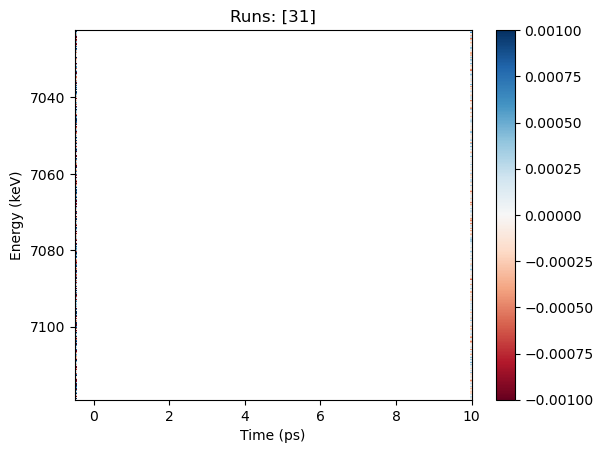

In [16]:
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_spectra(xes_analysis=xes,xes_key='epix_xray_not_laser_time_binned_ROI_1',
                  xes_laser_key='epix_simultaneous_laser_time_binned_ROI_1')
                  #dark_cutoff=10)
v.vmin=-0.001
v.vmax=0.001
v.plot_2d_difference_spectrum(xes)
plt.title("Runs: " + str(xes.runs))
#plt.xlim(-0.8,0.8)
#print('Run 23 Laser on shots - Laser off shots')

### Power Titration XES

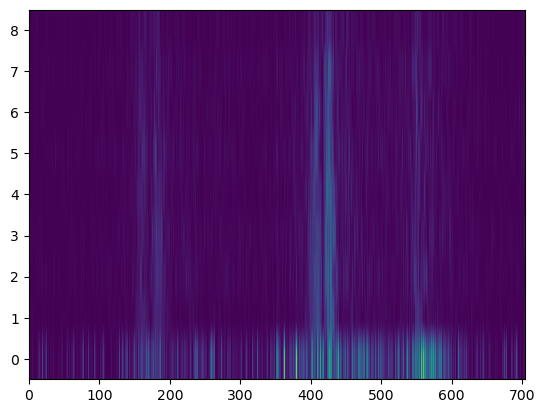

In [3]:
import numpy as np
file=h5py.File(r'/sdf/home/l/lbgee/links/mfx_experiments/mfx100894224/hdf5/smalldata/mfx100894224_Run0101.h5')
def filter_detector_adu(detector_images,adu_threshold=[3.0]):
    if isinstance(adu_threshold,list):
        detector_images_adu = detector_images * (detector_images > adu_threshold[0])
        detector_images_adu = detector_images * (detector_images < adu_threshold[1])
       
    else:
        detector_images_adu = detector_images * (detector_images > adu_threshold)
    return detector_images_adu
powers=np.array(file['scan/lasmot8'])
power_bins=np.arange(300,500,1)
epix=file['epix100/ROI_area']
laser_on=np.array(file['lightStatus/laser'])
epix_laser_on=np.array(epix)[laser_on]
epix_laser_off=np.array(epix)[~laser_on]

binned_epix_laser_on = np.digitize(powers[laser_on], power_bins)

# Bin epix_laser_off based on powers
binned_epix_laser_off = np.digitize(powers[~laser_on], power_bins)

# Fetch data
powers = np.array(file['scan/lasmot8'])
epix = np.array(file['epix100/ROI_area'])
epix=filter_detector_adu(epix,2)
laser_on = np.array(file['lightStatus/laser'])

# Split epix data based on laser status
epix_summed= np.nansum(epix,axis=2)
epix_laser_on = np.nansum(epix[laser_on],axis=2)
epix_laser_off = np.nansum(epix[~laser_on],axis=2)

# Define power bins
power_bins = np.linspace(500, 300, 9)

# Digitize powers for laser on and laser off
binned_powers=np.digitize(powers, power_bins)
sum_epix_laser_on = np.zeros([(np.shape(power_bins)[0] + 0) , epix.shape[1]], dtype=epix.dtype)
sum_epix_laser_off = np.zeros([(np.shape(power_bins)[0] + 0) , epix.shape[1]], dtype=epix.dtype)
for idx,i in enumerate( binned_powers):
    #if idx ==9:
     #   break
    if laser_on[idx]:
        sum_epix_laser_on[binned_powers[idx]] =sum_epix_laser_on[binned_powers[idx],:]+ epix_summed[idx,:]
    else:
        sum_epix_laser_off[binned_powers[idx]] =sum_epix_laser_off[binned_powers[idx]]+ epix_summed[idx]

# Assuming sum_epix_laser_on and sum_epix_laser_off are numpy arrays of shape (200, 704)
sum_epix_laser_on_normalizers = np.trapz(sum_epix_laser_on, axis=1)[:, np.newaxis]  # Shape becomes (200, 1)
sum_epix_laser_off_normalizers = np.trapz(sum_epix_laser_off, axis=1)[:, np.newaxis]  # Shape becomes (200, 1)

# Perform element-wise division
sum_epix_laser_on_norm = sum_epix_laser_on / sum_epix_laser_on_normalizers
sum_epix_laser_off_norm = sum_epix_laser_off / sum_epix_laser_off_normalizers
sum_epix_laser_on_norm  = np.nan_to_num(sum_epix_laser_on_norm , nan=0.0)
sum_epix_laser_off_norm  = np.nan_to_num(sum_epix_laser_off_norm , nan=0.0)



diff=np.abs(sum_epix_laser_on_norm-sum_epix_laser_off_norm)
plt.imshow(diff,origin='lower',aspect='auto')

Text(0.5, 0, 'Power')

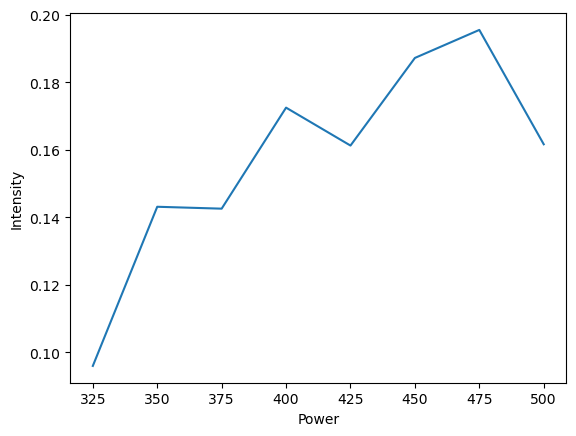

In [4]:
plt.plot(power_bins[:-1], np.nansum(diff[1:], axis=1))
plt.ylabel("Intensity")
plt.xlabel("Power")

## Diagnostics

Plotting various data streams (xray/laser status, delay stages, timetool, timestamp.  
**NOTE:** In DAQ2 era, HDF5 file is composed of multiple parts. The main file is a "virtual" file that points to the parts.   
This means the indexing in the file is scrambled and variables need to be plotted against the timestamp. 

### Loading HDF5

In [385]:
file_path = '/sdf/data/lcls/ds/mfx/mfx100894224/hdf5/smalldata/mfx100894224_Run0121.h5'
#!ls -lrt /sdf/data/lcls/ds/mfx/mfx100894224/hdf5/smalldata/mfx100894224_Run0043.h5
file = h5py.File(file_path, 'r')

### Listing Groups and Keys

In [375]:
list(file.keys())

['MfxDg1BmMon',
 'MfxDg2BmMon',
 'Sums',
 'UserDataCfg',
 'damage',
 'ebeamh',
 'epics',
 'epics_archiver',
 'epix100',
 'feespec',
 'gasdet',
 'lightStatus',
 'pcav',
 'qadc_ch0',
 'qadc_ch1',
 'scan',
 'timestamp',
 'timing',
 'tt']

In [386]:
def printnames(name):
    print(name)

file.visit(printnames)

MfxDg1BmMon
MfxDg1BmMon/peakAmplitude
MfxDg1BmMon/peakTime
MfxDg1BmMon/totalIntensityJoules
MfxDg1BmMon/xPositionMeters
MfxDg1BmMon/yPositionMeters
MfxDg2BmMon
MfxDg2BmMon/peakAmplitude
MfxDg2BmMon/peakTime
MfxDg2BmMon/totalIntensityJoules
MfxDg2BmMon/xPositionMeters
MfxDg2BmMon/yPositionMeters
Sums
Sums/epix100_calib
Sums/epix100_calib_dropped
Sums/epix100_calib_max
Sums/epix100_calib_thresADU1
Sums/jungfrau_calib
Sums/jungfrau_calib_dropped
Sums/jungfrau_calib_max
Sums/jungfrau_calib_thresADU1
UserDataCfg
UserDataCfg/MfxDg1BmMon
UserDataCfg/MfxDg1BmMon/detname
UserDataCfg/MfxDg1BmMon/name
UserDataCfg/MfxDg2BmMon
UserDataCfg/MfxDg2BmMon/detname
UserDataCfg/MfxDg2BmMon/name
UserDataCfg/ebeamh
UserDataCfg/ebeamh/detname
UserDataCfg/ebeamh/name
UserDataCfg/epics
UserDataCfg/epics/PV_0
UserDataCfg/epics/PV_1
UserDataCfg/epics/PV_2
UserDataCfg/epics/PVname_0
UserDataCfg/epics/PVname_1
UserDataCfg/epics/PVname_2
UserDataCfg/epics/detname
UserDataCfg/epics/name
UserDataCfg/epix100
UserDataCf

In [170]:
laser_status = file['lightStatus/laser']
xray_status = file['lightStatus/xray']

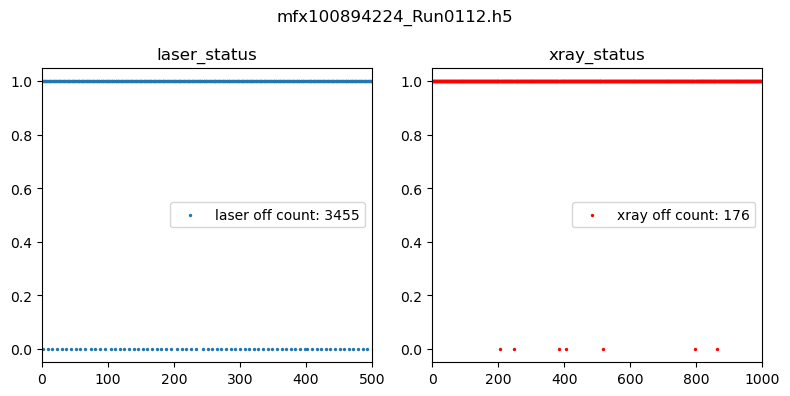

In [365]:
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
laser_off = len(laser_status) - np.sum(laser_status)
plt.scatter(np.arange(len(laser_status)),laser_status, s=2, label = "laser off count: " + str(laser_off))
plt.xlim(0, 500)
plt.legend()
plt.title("laser_status")

plt.subplot(1, 2, 2)
x_ray_on = np.sum(xray_status) 
x_ray_off = len(xray_status) - np.sum(xray_status) 
plt.scatter(np.arange(len(xray_status)),xray_status, s=2, color = 'r', label = "xray off count: " + str(x_ray_off))
plt.xlim(0, 1000)
plt.title("xray_status")
plt.legend()

plt.suptitle(file_path[-23:])

plt.tight_layout()

In [366]:
lxt_ttc = file['epics/lxt']
lxt_encoder = file['scan/mfx_lxt_fast1']
pulse_id = file['timing/pulseId']
pulse_timestamp = file['timing/timestamp']
tt_ampl = file['tt/ampl']
ipm = file['MfxDg2BmMon/totalIntensityJoules']

In [367]:
data = [ipm, pulse_id, pulse_timestamp, lxt_ttc, lxt_encoder, tt_ampl]

In [368]:
for x in range(len(data)):
    print("DATA: " + str(data[x]))
    print("\t", "MAX: ", np.max(data[x]), "| MIN: ", np.min(data[x]))

DATA: <HDF5 dataset "totalIntensityJoules": shape (26400,), type "<f8">
	 MAX:  688329.25 | MIN:  -2067.375
DATA: <HDF5 dataset "pulseId": shape (26400,), type "<i8">
	 MAX:  1695441102789 | MIN:  1695028782504
DATA: <HDF5 dataset "timestamp": shape (26400,), type "<i8">
	 MAX:  4790323642998505265 | MIN:  4790321735995772566
DATA: <HDF5 dataset "lxt": shape (26400,), type "<f8">
	 MAX:  1.000000000239362e-12 | MIN:  1.000000000239362e-12
DATA: <HDF5 dataset "mfx_lxt_fast1": shape (26400, 1), type "<f8">
	 MAX:  3.99998721782386e-12 | MIN:  3.99998721782386e-12
DATA: <HDF5 dataset "ampl": shape (26400,), type "<f8">
	 MAX:  nan | MIN:  nan


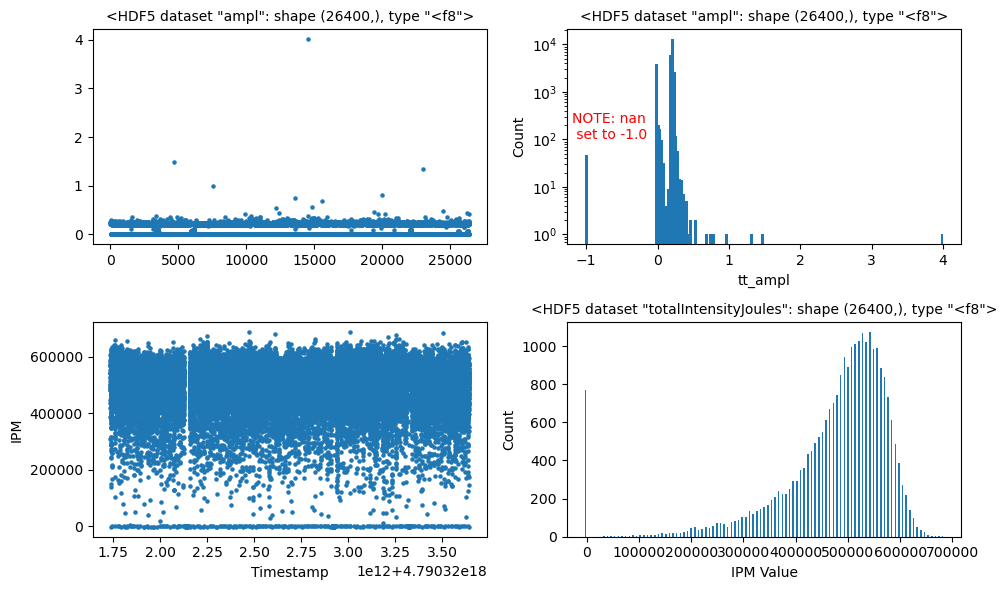

In [369]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.scatter(np.arange(len(lxt_encoder)), tt_ampl, s =5 )
plt.title(str(tt_ampl), fontsize=10)

plt.subplot(2, 2, 2)

## set nans to -1.0
tt_ampl_nan_clean = np.nan_to_num(tt_ampl, nan=-1.0)
ttamphis = np.histogram(tt_ampl_nan_clean, 
                        bins = np.linspace(np.min(tt_ampl_nan_clean), np.max(tt_ampl_nan_clean), 200))
counts, bins = ttamphis

plt.bar(bins[:-1], counts, width=0.04)
plt.yscale('log')
plt.title(str(tt_ampl), fontsize=10)
plt.ylabel('Count')
plt.xlabel('tt_ampl')
plt.text(-1.2, 100, "NOTE: nan \n set to -1.0", c = 'r')



plt.subplot(2, 2, 3)
plt.scatter(pulse_timestamp, ipm, s = 5)
plt.ylabel("IPM")
plt.xlabel("Timestamp")


plt.subplot(2, 2, 4)
ipm_hist = np.histogram(ipm, bins =  np.linspace(np.min(ipm), np.max(ipm), 100))
counts, bins = ipm_hist
#bins
plt.bar(bins[:-1], counts, width=3000)
#plt.yscale('log')
plt.title(str(ipm), fontsize=10)
plt.ylabel('Count')
plt.xlabel('IPM Value')

plt.tight_layout()

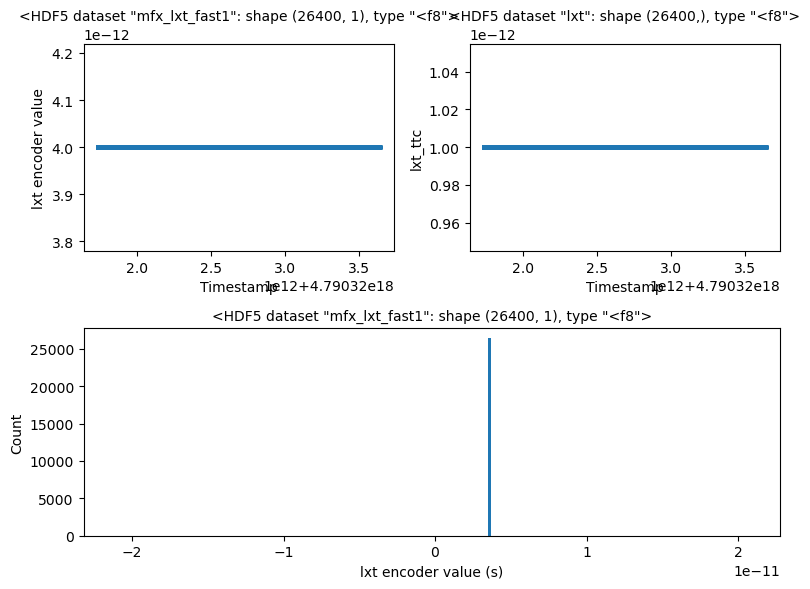

In [370]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
plt.scatter(pulse_timestamp, lxt_encoder, s = 5)
plt.ylabel("lxt encoder value")
plt.xlabel("Timestamp")
plt.title(str(lxt_encoder), fontsize=10)

plt.subplot(2, 2, 2)
plt.scatter(pulse_timestamp, lxt_ttc, s =5)
plt.ylabel("lxt_ttc")
plt.xlabel("Timestamp")
plt.title(str(lxt_ttc), fontsize=10)

plt.subplot(2, 2, (3,4))
pico = 1e-12
lxt_encoder_hist = np.histogram(lxt_encoder, bins =  np.linspace(-21*pico, 21*pico, 100))

counts, bins = lxt_encoder_hist
#bins
plt.bar(bins[:-1], counts, width = 2e-13)
plt.ylabel("Count")
plt.xlabel("lxt encoder value (s)")
plt.title(str(lxt_encoder), fontsize=10)
          
plt.tight_layout()

In [347]:
def run_checker(path, runs, extension, key_timestamp, keys, verbose=False):
    for x in keys:
        plt.figure(figsize=(8,4))
        all_data = []
        for y in runs:
            filepath = path + y + extension
            file = h5py.File(filepath, 'r')
            timestamp = file[key_timestamp]
            data = file[x]
            if verbose==True:
                print(filepath)
                print(file)
                print(timestamp)
                print(data)
            plt.scatter(timestamp, data, label = str(file)[25:-14], s = 1)
            plt.ylabel(x)
            plt.xlabel(key_timestamp)
            plt.legend(fontsize=10,bbox_to_anchor=(1.01, 1.00))
        plt.show()

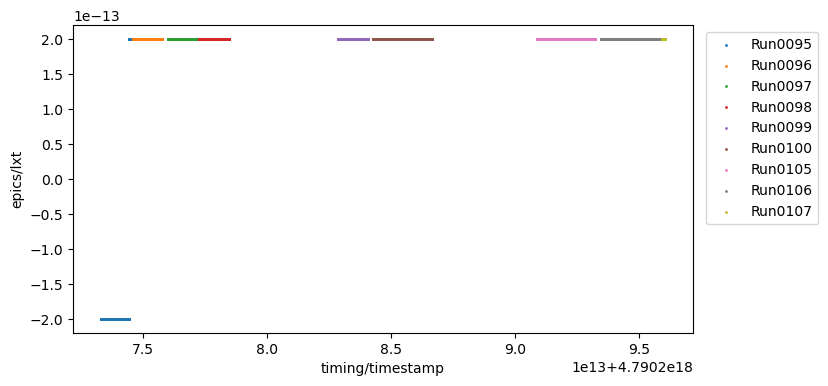

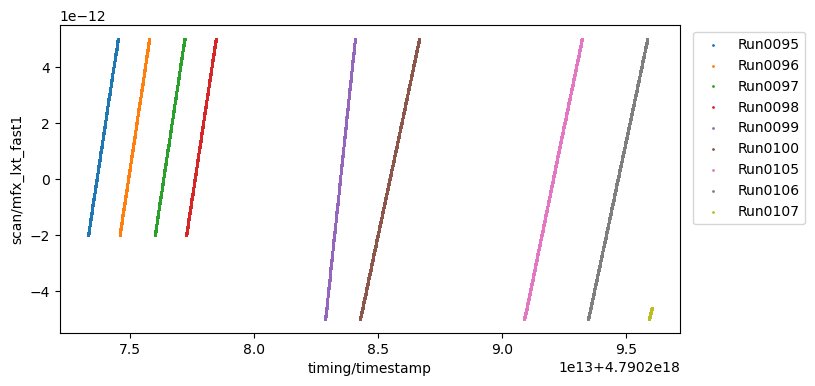

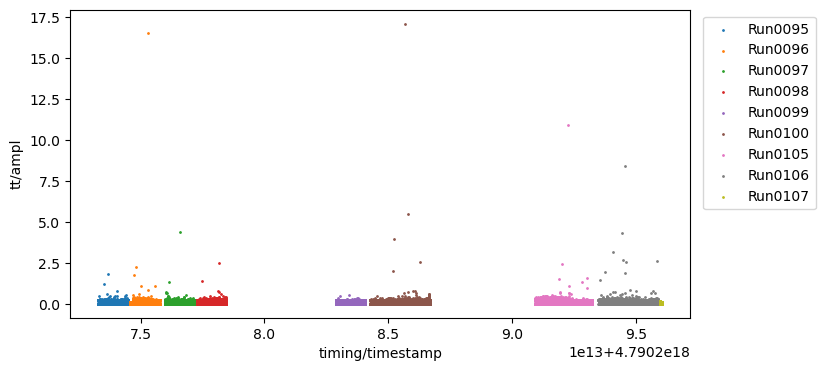

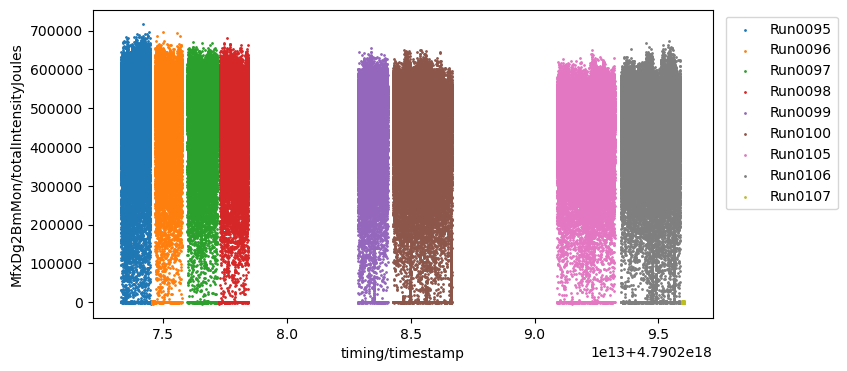

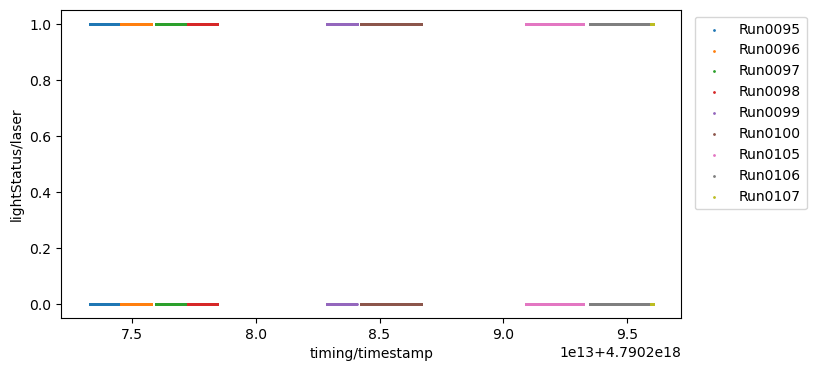

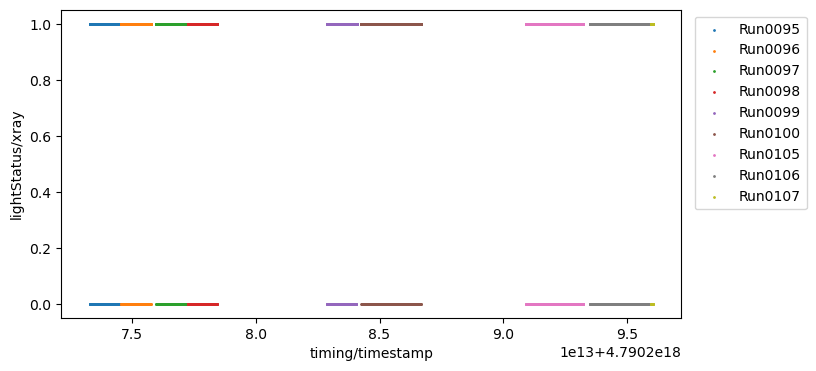

In [388]:
path = '/sdf/data/lcls/ds/mfx/mfx100894224/hdf5/smalldata/mfx100894224_Run'
runs = ['0095', '0096', '0097', '0098', '0099', '0100', '0105', '0106', '0107']
extension = '.h5'
key_timestamp = 'timing/timestamp'
keys = ['epics/lxt', 'scan/mfx_lxt_fast1', 'tt/ampl','MfxDg2BmMon/totalIntensityJoules', 'lightStatus/laser', 'lightStatus/xray']

run_checker(path, runs, extension, key_timestamp, keys)

/sdf/data/lcls/ds/mfx/mfx100894224/hdf5/smalldata/mfx100894224_Run0111.h5
<HDF5 file "mfx100894224_Run0111.h5" (mode r)>
<HDF5 dataset "timestamp": shape (26400,), type "<i8">
<HDF5 dataset "lxt": shape (26400,), type "<f8">


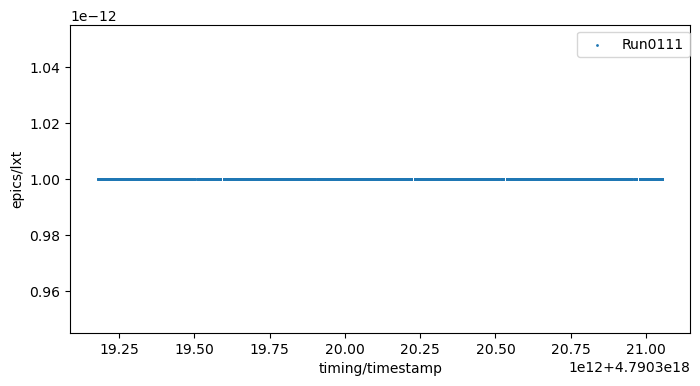

/sdf/data/lcls/ds/mfx/mfx100894224/hdf5/smalldata/mfx100894224_Run0111.h5
<HDF5 file "mfx100894224_Run0111.h5" (mode r)>
<HDF5 dataset "timestamp": shape (26400,), type "<i8">
<HDF5 dataset "mfx_lxt_fast1": shape (26400, 1), type "<f8">


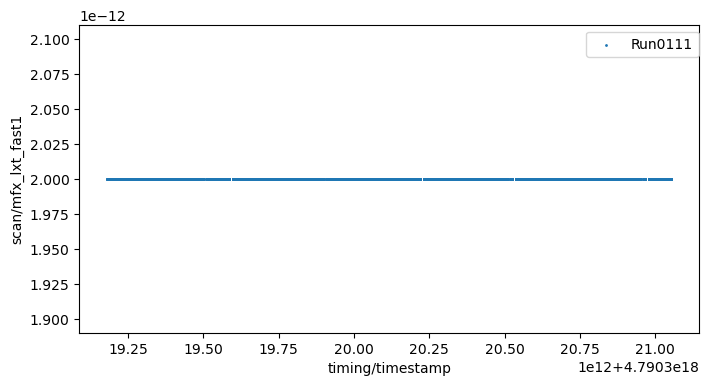

/sdf/data/lcls/ds/mfx/mfx100894224/hdf5/smalldata/mfx100894224_Run0111.h5
<HDF5 file "mfx100894224_Run0111.h5" (mode r)>
<HDF5 dataset "timestamp": shape (26400,), type "<i8">
<HDF5 dataset "ampl": shape (26400,), type "<f8">


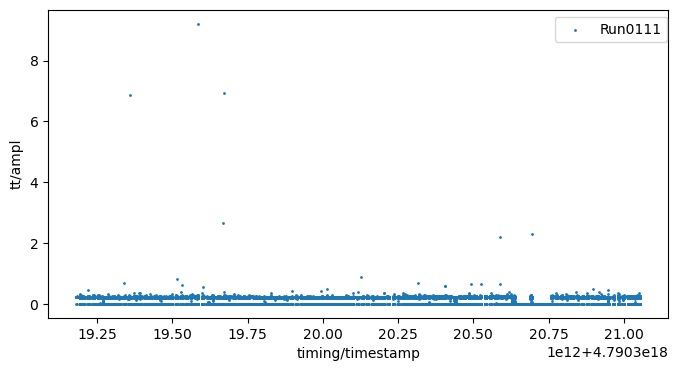

/sdf/data/lcls/ds/mfx/mfx100894224/hdf5/smalldata/mfx100894224_Run0111.h5
<HDF5 file "mfx100894224_Run0111.h5" (mode r)>
<HDF5 dataset "timestamp": shape (26400,), type "<i8">
<HDF5 dataset "totalIntensityJoules": shape (26400,), type "<f8">


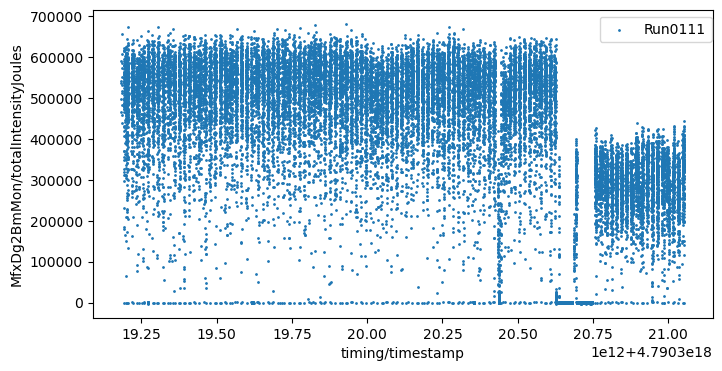

/sdf/data/lcls/ds/mfx/mfx100894224/hdf5/smalldata/mfx100894224_Run0111.h5
<HDF5 file "mfx100894224_Run0111.h5" (mode r)>
<HDF5 dataset "timestamp": shape (26400,), type "<i8">
<HDF5 dataset "laser": shape (26400,), type "<i8">


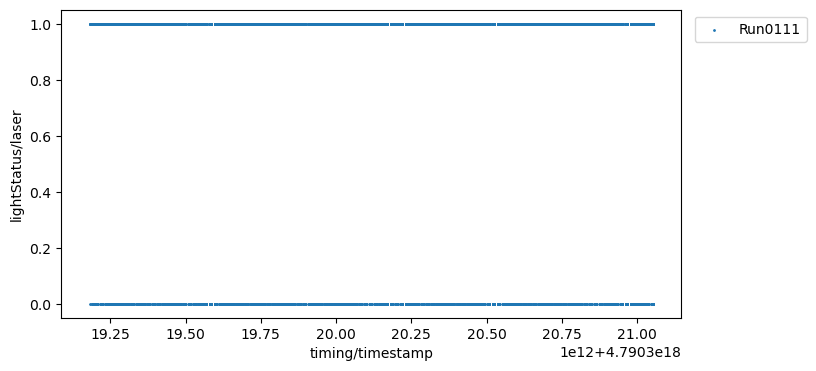

/sdf/data/lcls/ds/mfx/mfx100894224/hdf5/smalldata/mfx100894224_Run0111.h5
<HDF5 file "mfx100894224_Run0111.h5" (mode r)>
<HDF5 dataset "timestamp": shape (26400,), type "<i8">
<HDF5 dataset "xray": shape (26400,), type "<i8">


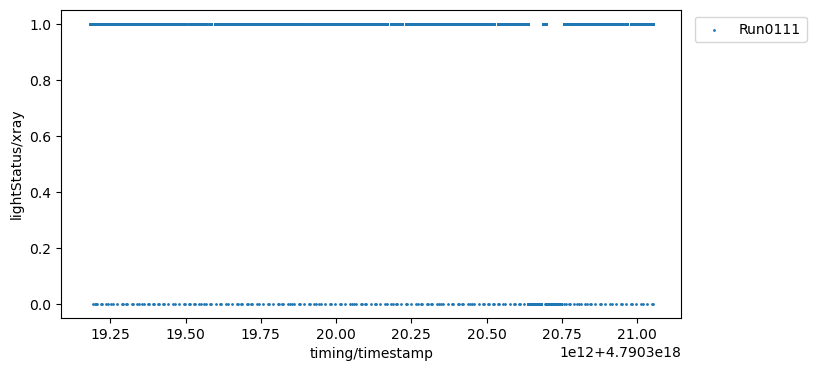

In [354]:
path = '/sdf/data/lcls/ds/mfx/mfx100894224/hdf5/smalldata/mfx100894224_Run'
runs = ['0101', '0102', '0103', '0104', '0111']
runs = ['0111']
extension = '.h5'
key_timestamp = 'timing/timestamp'
#keys = ['epics/lxt', 'scan/lasmot8', 'tt/ampl','MfxDg2BmMon/totalIntensityJoules', 'lightStatus/laser', 'lightStatus/xray']
keys = ['epics/lxt', 'scan/mfx_lxt_fast1', 'tt/ampl','MfxDg2BmMon/totalIntensityJoules', 'lightStatus/laser', 'lightStatus/xray']

run_checker(path, runs, extension, key_timestamp, keys, verbose = True)